# 09. 분류 실습 - 캐글 신용카드 사기 검출

<br>

# 1. 신용카드 데이터 세트

Kaggle의 신용카드 데이터 세트를 이용 신용카드 사기 검출 분류 실습 수행  
[링크](https://www.kaggle.com/mlg-ulb/creditcardfraud)에서 데이터셋 다운로드 가능

해당 데이터 세트의 레이블은 `Class` 속성은 매우 불균형한 분포를 가지고 있음  
Class는 0과 1로 분류됨  
$\rightarrow$ 0 : 사기가 아닌 정상적인 트랜잭션  
$\rightarrow$ 1 : 신용카드 사기 트랜잭션  
전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션이다.

<br>

# 2. 언더 샘플링과 오버 샘플링의 이해

## 2.1 불균형한 레이블 값 분포의 문제점

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있음  
$\rightarrow$ 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생  

이상 레이블을 가지는 데이터 건수는 매우 작기 때문에 제대로 다양한 유형을 학습하지 못함  
정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행  
$\rightarrow$ 제대로 된 이상 데이터 검출이 어려워지기 쉬움

지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해 적절한 학습 데이터를 확보하는 방법 필요  
$\rightarrow$ 오버 샘플링(Oversampling), 언더 샘플링(Undersampling)

<br>

## 2.2 언더 샘플링(Undersampling) vs 오버 샘플링(Oversampling)

### 2.2.1 언더 샘플링(Undersampling)

<div style='text-align: left; margin-left: 20px;'>
    <img src='./images/Ch04/09/img001.jpg' width='400px'/>
</div>

- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
- 정상 레이블 데이터를 이상 레이블 데이터 수준ㅇ느로 줄여 버린 상태에서 학습을 수행  
$\rightarrow$ 과도하게 정상 레이블로 학습/예측하는 부작용은 개선 가능  
$\rightarrow$ 너무 많은 정상 레이블 데이터를 감소시키기 때문에 정상 레이블에 대한 제대로 된 학습을 할 수 없음
- 잘 적용하지 않는 방법

<br>

### 2.2.2 오버 샘플링(Oversampling)

<div style='text-align: left; margin-left: 20px;'>
    <img src='./images/Ch04/09/img002.jpg' width='400px'/>
</div>

- 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
- 동일한 데이터를 단순히 증식하는 방법  
$\rightarrow$ 과적합(Overfitting) 됨 (의미가 없음)  
$\Rightarrow$  원본 데이터의 피처 값들을 아주 약간만 변경하여 증식함

<br>

**SMOTE(Synthetic Minority Over-sampling Technique)**

- 데이터를 증식하는 대표적인 방법 중 하나
- 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

<div style='text-align: left; margin-left: 20px;'>
    <img src='./images/Ch04/09/img003.jpg' width='700px'/>
</div>

- SMOTE를 구현한 대표적인 파이썬 패키지 $\rightarrow$ `imbalanced-learn`

<br>

# 3. 데이터 일차 가공 및 모델 학습/예측/평가

## 3.1 데이터 세트 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('./data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


<br>

## 3.2 피처들의 특징

**Vn**

V로 시작하는 피처들의 의미는 알 수가 없다.

**Time**

Time 피처의 경우 데이터 생성 관련한 작업용 속성 $\rightarrow$ 제거

**Amount**

신용카드 트랜잭션 금액을 의미

**Class**

레이블 (0: 정상, 1: 사기)

In [2]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

$\rightarrow$ 전체 레코드 수 : 284,807개  
$\rightarrow$ Null 값은 없음  
$\rightarrow$ Class 레이블만 int형이고 나머지 피처들은 모두 float형

<br>

## 3.3 사용자 정의 함수

`get_preprocessed_df()`  

- 인자로 입력된 DataFrame을 복사
- 이를 가공하여 변환하는 함수

`get_train_test_dataset()`

- 데이터 가공 후 학습/테스트 데이터 세트를 반환하는 함수

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None) :
    
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # train_test_split()으로 학습과 테스트 분할
    # stratify=y_target으로 Stratified 기반 분할(학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만듬)
    X_train, X_test, y_train, y_test = train_test_split(X_features,
                                                        y_target,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

<br>

학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하게 분할됐는 지 확인

In [6]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


<br>

## 3.4 모델 생성

로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는 지 확인

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    # ROC AUC
    auc_score = roc_auc_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    
    # f1 score print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, auc_score))

<br>

### 3.4.1 로지스틱 회귀

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred)

오차 행렬
[[85282    13]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8738, 재현율 : 0.6081, F1 : 0.7171, AUC : 0.8040


$\rightarrow$ 재현율(Recall) : 60.81%  
$\rightarrow$ ROC-AUC : 80.40%

<br>

### 3.4.2 LightGBM

`get_model_train_eval()`

- 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측/평가를 수행
- 이에 따른 별도의 함수 생성  
  
  
- 해당 함수는 인자
  - 사이킷런의 Estimator 객체
  - 학습/테스트 데이터 세트
  
  
- 위의 입력 인자를 받아 학습/예측/평가를 수행하는 역할을 하는 함수

In [9]:
# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None) :
    
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)

<br>

`boost_from_average=False`

- 본 데이터 세트가 극도로 불균형한 레이블 값 분포도를 가지고 있음
- 따라서 `LGBMClassifier` 객체 생성 시 `boost_from_average=False`로 파라미터를 설정해야 한다.  
  
  
- LightGBM이 버전업되면서 `boost_from_average` 파라미터의 디폴트 값이 `False`에서 `True`로 변경됨
- LightGBM 2.1.0 이상의 버전이 설치되어 있거나 불균형한 데이터 세트에서 예측 성능이 매우 저조하다.  
$\rightarrow$ `LGBMClassifier` 객체 생성 시 `boost_from_average=False`로 파라미터를 설정

In [10]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,
                          n_jobs=-1,
                          boost_from_average=False)
get_model_train_eval(lgbm_clf, 
                     ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9492, 재현율 : 0.7568, F1 : 0.8421, AUC : 0.8783


$\rightarrow$ 재현율(Recall) : 75.68% (로지스틱 회귀의 60.81%보다 개선됨)  
$\rightarrow$ ROC-AUC : 87.83% (로지스틱 회귀의 80.40%보다 개선됨)

<br>

# 4. 데이터 분포도 변환 후 모델 학습/예측/평가

왜곡된 분포도를 가지는 데이터를 재가공한 뒤 모델을 다시 테스트

<br>

## 4.1 중요 피처 값의 분포도 확인

로지스틱 회귀는 선형 모델이다.  
대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다.

**Amount 피처**

- 신용 카드 사용 금액
- 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다.

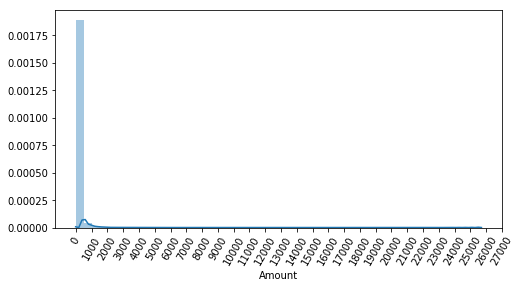

In [11]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])
plt.show()

$\rightarrow$ Amount(카드 사용금액)가 1000불 이하인 데이터가 대부분  
$\rightarrow$ 27,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있음

<br>

## 4.2 `StandardScaler` 이용 분포 변환

Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정  
`get_processed_df()` 함수에 사이킷런의 `StandardScaler` 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경

<br>

### 4.2.1 정규 분포 형태로 변환

In [12]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None) :
    
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    return df_copy

<br>

### 4.2.2 분포 변환 후 모델 학습/예측/평가

In [13]:
# Amount를 정규 분포 형태로 변환한 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [14]:
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,
                     ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081, F1 : 0.7143, AUC : 0.8040


$\rightarrow$ 재현율(Recall) : 60.81% (분포 변환 전과 차이 없음)  
$\rightarrow$ ROC-AUC : 80.40% (분포 변환 전과 차이 없음)

<br>

In [15]:
print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,
                     ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9492, 재현율 : 0.7568, F1 : 0.8421, AUC : 0.8783


$\rightarrow$ 재현율(Recall) : 71.68% (분포 변환 전과 차이 없음)  
$\rightarrow$ ROC-AUC : 87.83% (분포 변환 전과 차이 없음)

<br>

## 4.3 `log1p()` 함수 이용 로그 변환

### 4.3.1 로그 변환

- 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나  
- 원래 값을 log 값으로 변환  
- 원래 큰 값을 상태적으로 작은 값으로 변환  
$\rightarrow$ 데이터 분포도의 왜곡을 상당 수준 개선  
  
  
- 넘파이의 `log1p()` 함수를 이용해 간단히 변환 가능


In [16]:
def get_preprocessed_df(df=None) :
    
    df_copy = df.copy()
    
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    return df_copy

<br>

### 4.3.2 로그 변환 후 모델 학습/예측/평가

In [17]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [18]:
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,
                     ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8824, 재현율 : 0.6081, F1 : 0.7200, AUC : 0.8040


$\rightarrow$ 재현율(Recall) : 60.81% (분포 변환 전과 차이 없음)  
$\rightarrow$ ROC-AUC : 80.40% (분포 변환 전과 차이 없음)

<br>

In [19]:
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,
                     ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576, 재현율 : 0.7635, F1 : 0.8496, AUC : 0.8817


$\rightarrow$ 재현율(Recall) : 76.35% (분포 변환 전 75.68%보다 성능이 약간 개선됨)  
$\rightarrow$ ROC-AUC : 88.17% (분포 변환 전 87.83%보다 성능이 약간 개선됨)

<br>

# 5. 이상치 데이터 제거 후 모델 학습/예측/평가

## 5.1 이상치 데이터(Outlier)

- 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
- 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생

<br>

## 5.2 IQR(Inter Quantile Range)

- 이상치를 찾아내는 방법 중 하나
- 사분위(Quantile) 값의 편차를 이용하는 기법
- 박스 플롯(Box Plot)방식으로 시각화할 수 있음

<br>

### 5.2.1 사분위(Quantile)

- 전체 데이터를 값이 높은 순으로 정렬
- 이를 1/4(25%)씩으로 구간을 분할하는 것  
  
  
- 25% 구간인 Q1 ~ 75% 구간인 Q3의 범위를 **IQR**이라고 한다.

<div style='text-align: left; margin-left: 20px;'>
    <img src='./images/Ch04/09/img004.jpg' width='500px'/>
</div>

<br>

## 5.3 IQR 이용 이상치 데이터 검출 방식

- IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값 결정
- 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주  
  
  
- 3/4 분위수(Q3)에 IQR * 1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 가정  
$\rightarrow$ 최댓값 = Q3 + (IQR * 1.5)  
  
  
- 1/4 분위수(Q1)에 IQR * 1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정  
$\rightarrow$ 최솟값 = Q1 - (IQR * 1.5)  
  
  
- 1.5가 아닌 다른 값을 적용할 수 도 있음 (보통은 1.5 적용)  
  
  
- 이렇게 결정된 최댓값보다 큰 값 또는 최솟값보다 작은 값을 이상치 데이터로 간주

<br>

## 5.4 박스 플롯(Box Plot)

- IQR 방식을 시각화한 도표
- 아래 그림과 같은 표현 방식으로 사분위의 편차와 IQR, 그리고 이상치를 나타냄

<div style='text-align: left; margin-left: 20px;'>
    <img src='./images/Ch04/09/img005.jpg' width='500px'/>
</div>

<br>

## 5.5 이상치 데이터 제거

- IQR을 이용해 이상치 제거  
  
  
- 어떤 피처의 이상치 데이터를 검출할 것인 지 선택이 필요
- 매우 많은 피처가 있을 경우, 이들 중 **결정값(레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출**하는 것이 좋다.
- 모든 피처들의 이상치를 검출하는 방법
  - 시간이 많이 소모
  - 결정값과 상관성이 높지 않은 피처들의 경우는 이상치를 제거하더라도 크게 성능 향상에 기여하지 않음


<br>

### 5.5.1 피처별 상관도 시각화

- DataFrame의 `corr()` 이용해 각 피처별로 상관도를 구함
- 시본의 `heatmap`을 통해 시각화

`cmap='RdBu'`  

- 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까움
- 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가까움

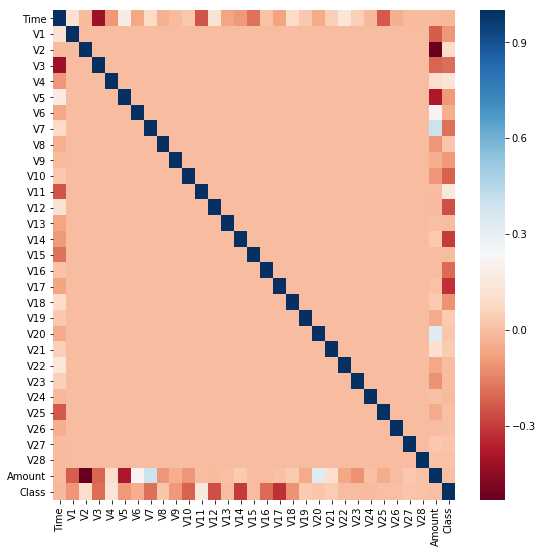

In [20]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

맨 아래의 위치한 결정 레이블(Class) 피처와 **음의 상관관계**가 높은 피처  
$\rightarrow$ V14, V17

이 중 V14에 대해서만 이상치를 찾아서 제거

<br>

### 5.5.2 이상치 제거 함수 정의

`get_outlier(df, column, weight)`

- 입력 인자
  - DataFrame
  - 이상치를 검출할 컬럼  
  
  
- 함수 내에서 넘파이의 `percentile()`을 이용해 1/4 분위수와 3/4 분위수를 구함
- 이에 기반해 IQR를 계산
- 계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구함
- 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정
- 해당 이상치가 있는 DataFraem Index를 반환

In [21]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5) :
    
    # fraud에 해당하는 column 데이터만 추출
    # 1/4 분위와 3/4 분위 지점을 np.percentile()로 구함
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정
    # 해당하는 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

<br>

### 5.5.3 V14 컬럼에 대한 이상치 제거

`get_outlier()` 함수를 이용해 V14 컬럼에서 이상치 데이터 찾기

In [22]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


$\rightarrow$ 총 4개의 데이터가 이상치로 추출됨

<br>

`get_outlier()` 함수를 이용해 이상치를 추출하고 이를 삭제하는 로직을 `get_processed_df()` 함수에 추가

In [23]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None) :
    
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

In [24]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [25]:
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, 
                     ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85278    17]
 [   61    85]]
정확도 : 0.9991, 정밀도 : 0.8333, 재현율 : 0.5822, F1 : 0.6855, AUC : 0.7910


$\rightarrow$ 재현율(Recall) : 58.22% (이상치 제거 전 60.81%보다 성능이 하락함)  
$\rightarrow$ ROC-AUC : 79.10% (이상치 제거 전 80.40%보다 성능이 하락함)

<br>

In [26]:
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,
                     ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   26   120]]
정확도 : 0.9996, 정밀도 : 0.9677, 재현율 : 0.8219, F1 : 0.8889, AUC : 0.9109


$\rightarrow$ 재현율(Recall) : 82.19% (이상치 제거 전 76.35%보다 성능이 향상됨)  
$\rightarrow$ ROC-AUC : 91.09% (이상치 제거 전 88.17%보다 성능이 향상됨)

<br>

# 6. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능을 평가  
  
  
SMOTE는 `imbalanced-learn` 패키지의 SMOTE 패키지 클래스를 이용해 간단하게 구현 가능   
  
  
SMOTE를 적용할 때는 반드시 **학습 데이터만 오버 샘플링**을 해야 한다.  
검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행  
$\rightarrow$ 올바른 검증/테스트가 될 수 없다.

<br>

## 6.1 SMOTE 이용, 데이터 증식

SMOTE 객체의 `fit_sample()` 메서드를 이용해 증식한 뒤 데이터를 증식 전과 비교

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 31) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 31) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 1    199020
0    199020
dtype: int64


$\rightarrow$ SMOTE 적용 후 2배에 가까운 398,040건으로 데이터가 증식된 것 확인  
$\rightarrow$ SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020건으로 생성됨

<br>

## 6.2 증식된 학습 데이터 세트 기반 모델 학습

### 6.2.1 로지스틱 회귀

In [31]:
lr_clf = LogisticRegression()

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf,
                     ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[83997  1298]
 [   14   132]]
정확도 : 0.9846, 정밀도 : 0.0923, 재현율 : 0.9041, F1 : 0.1675, AUC : 0.9444


$\rightarrow$ 재현율(Recall) : 90.41% (SMOTE 적용 전 58.22%보다 성능이 많이 개선됨)  
$\rightarrow$ ROC-AUC : 94.44% (SMOTE 적용 전 79.10%보다 성능이 많이 개선됨)

$\rightarrow$ 하지만 정밀도가 96.77%에서 9.23%로 급격하게 저하됨

재현율이 높더라도 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없다.  
이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 `Class=1` 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 `Class=1`로 적용해 정밀도가 급격히 떨어지게 된 것

<br>

**분류 결정 임곗값에 따른 정밀도와 재현율 곡선 시각화**

SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는 지 시각적으로 확인  
`precision_recall_curve_plot()` 함수 이용

In [32]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1) :
    
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds,
             precisions[0:threshold_boundary],
             linestyle='--',
             label='precision')
    plt.plot(thresholds,
             recalls[0:threshold_boundary],
             label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

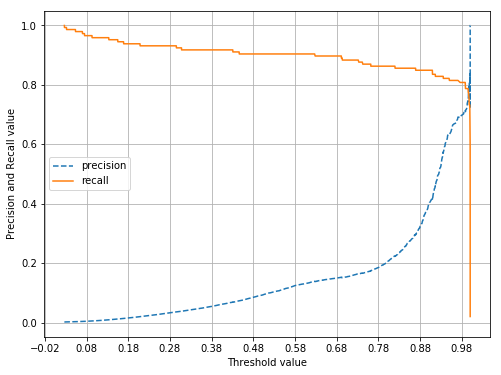

In [33]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

$\rightarrow$ 임계값 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮음  
$\rightarrow$ 임계값 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다.

분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없다.  
$\rightarrow$ 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못했다.

<br>

### 6.2.2 LightGBM

In [34]:
lgbm_clf = LGBMClassifier(n_estimators=1000,
                          num_leaves=64,
                          n_jobs=-1,
                          boost_from_average=False)
get_model_train_eval(lgbm_clf,
                     ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85285    10]
 [   25   121]]
정확도 : 0.9996, 정밀도 : 0.9237, 재현율 : 0.8288, F1 : 0.8736, AUC : 0.9143


$\rightarrow$ 재현율(Recall) : 82.88% (SMOTE 적용 전 82.19%보다 성능이 조금 향상됨)  
$\rightarrow$ ROC-AUC : 91.43% (SMOTE 적용 전 91.09%보다 성능이 조금 향상됨)

$\rightarrow$ 정밀도(Precision) : 92.37% (SMOTE 적용 전 96.77%보다 조금 낮아짐)

좋은 SMOTE 패키지일수록 재현율 증가율은 높고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.

<br>

# 7. 데이터 가공 유형별 각 모델의 평가 지표

<div style='text-align: left; margin-left: 20px;'>
    <img src='./images/Ch04/09/img006.jpg' width='600px'/>
</div>